In [3]:
# Loading of libraries
import numpy as np
import scipy.spatial.distance
import matplotlib.pyplot as plt
from numba import jit, vectorize, float64

%matplotlib inline

In [131]:
# Design variables
AverageRadius            = 1
DeviationRadius          = AverageRadius / 10
ParticleCount            = 500
Viscosity                = 1E3
ViscosityR               = 32 / 3 * Viscosity
RotationalViscoisty      = 1E3
RotationalViscoistyR     = 4 * np.pi * RotationalViscoisty
NeighbourDistance        = 2.7 * AverageRadius
SpringConstant           = 1
Chi                      = 1         # Rotational viscosity    - 1 in natural units
Zeta                     = 1         # Translational visocsity - 1 in natural units
k                        = 1         # Sprint constant         - 1 in natural units

# Simulation variables
NeighbourCutoff          = 2.7
TimeStep                 = 0.01
L_align                  = 0.1       # Range from 0.1 to 1
L_noise                 = 0.04      # Range from 0.04 to 0.08
L_F_in                   = 0.3
L_T_in                   = 3
L_self                   = 0.03
T_align                  = L_align * k * Chi / Zeta
T_noise                  = np.sqrt(L_noise / Zeta / TimeStep * 2 * k * Chi**2)
F_in                     = L_F_in * AverageRadius * k
T_in                     = L_T_in * Chi * k / Zeta
F_self                   = L_self * k * AverageRadius


# Initiate the pengiuins
Radius                   = np.random.normal(AverageRadius, DeviationRadius, ParticleCount)
Location                 = (np.vstack((
                             np.tile(np.arange(0,10), ParticleCount / 10) * 1,
                             np.repeat(np.arange(0,ParticleCount / 10), 10) * 1
                           ))).T# + np.random.normal(0,1,(ParticleCount,2))
Velocity                 = np.zeros([ParticleCount, 2])
Orientation              = np.ones(ParticleCount) * np.pi / 2 + np.random.uniform(-np.pi/4, np.pi/4, ParticleCount)
AngularVelocity          = np.zeros(ParticleCount)


float64


In [ ]:
@vectorize([float64(float64, float64)])
def norm

In [195]:
def ParticleForce(AngleRange, Boundary, Orientation, Overlap, F_self, F_in, k):
    # Particle force = Self-Propulsion + Boundary + Repulsion
    
    Dir =  np.array([np.cos(Orientation), np.sin(Orientation)])
    PropulsionForce = F_self * Dir
    BoundaryForce   = F_in * (AngleRange - pi) * Boundary * Dir
    RepulsionForce  = k * Overlap.T;
    
    return np.transpose(PropulsionForce + BoundaryForce + RepulsionForce)

#@jit(['float64[:], float64[:], float64[:](float64[:], float64[:], int64[:], float64, float64, float64)'])
def ParticleTorque(Orientation, AvgAngles, Boundary, T_in, T_noise, T_align):
    # Particletorque = Self-Torque + Noise + Align
    deltaTheta = Orientation - AvgAngles
    BoundaryTorque = T_in * deltaTheta * Boundary
    NoiseTorque    = T_noise * np.random.uniform(-1,1,Orientation.shape[0])
    AlignTorque    = T_align * deltaTheta;
    
    return BoundaryTorque + NoiseTorque + AlignTorque

## This functions creates a list of neighbours for all particles
#  ParticleLocations is the Nx2 array containing the locations of the particles
def NeighbourMatrix(Location):
    Distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Location))
    Neighbours = (Distances < NeighbourCutoff) & ~np.eye(Location.shape[0], dtype=np.bool);
    return Neighbours
    
@jit(nopython=True)
def NeighbourAngles(Location, Orientation, Neighbours):
    n = Location.shape[0]
    ThetaOut = np.zeros((n))
    DeltaTheta = np.zeros((n))
    for i in range(n):
        # select neighbours
        CurrentNeighbours = np.where(Neighbours[i,:])[0]
        NumNeighbours = CurrentNeighbours.shape[0]
        
        if (NumNeighbours > 1):
            # calculate angles between neighbours and order them
            Offsets = Location[CurrentNeighbours,:] - Location[i,:]
            Angles = np.arctan2(Offsets[:,1], Offsets[:,0]) % (2*np.pi)
            SortedAngles = np.sort(Angles)
            
            # calculate angle differences between subsequent neighbours
            DiffAngles = np.zeros((NumNeighbours))
            # numba doesn't support roll unfortunately
            for j in range(NumNeighbours):
                DiffAngles[j] = ((SortedAngles[((j+1)%NumNeighbours)] - SortedAngles[j])) % (2*np.pi)
            
            # determine the largest gap in angles, which corresponds to theta-out
            ThetaOut[i] = np.max(DiffAngles)
            
            # calculate the absolute angle of the theta-in direction
            BoundaryNeighbour = np.argmax(DiffAngles)
            ThetaIn = (SortedAngles[BoundaryNeighbour] - 0.5 * (2*np.pi - ThetaOut[i])) % (2*np.pi)
            
            # calculate signed angle difference between orientation and theta-in
            DeltaTheta[i] = (ThetaIn - (Orientation[i] % (2*np.pi)))
            DeltaTheta[i] = (DeltaTheta[i] + np.pi) % (2*np.pi) - np.pi
    return ThetaOut, DeltaTheta
            
        

def NeighbourOverlap(Location, Neighbours, Radius):
    Overlap = np.zeros([Location.shape[0],2])
    for i in range(0,Location.shape[0]):
        N = Neighbours[:,0] == i
        Neigh = Neighbours[np.nonzero(N), 1]
        Dir = Location[i,:] - Location[Neigh, :]
        d = np.sqrt(np.sum(np.power(Dir, 2), axis=2))
        # Overlap function between two circles
        r = Radius[Neigh]
        R = Radius[i]
        A = r**2 * np.arccos((d**2 + r**2 - R**2) / (2*d*r))
        A = A + R**2 * np.arccos((d**2 + R**2 - r**2) / (2*d*R))
        A = A - 0.5 * np.sqrt((-d+r+R)*(d+r-R)*(d-r+R)*(d+r+R))
        A = A * np.linalg.norm(Dir, axis=2)
        A = A.T * Dir
        A = np.sum(np.nan_to_num(A),axis=1)
        Overlap[i,:] = A
    return Overlap

    def NeighbourAngles(Location, Neighbours):
        NeighbourOffset = (Location[np.newaxis,:,:] * Neighbours[:,:,np.newaxis]) - (Location[:,np.newaxis,:] * Neighbours[:,:,np.newaxis])
        NeighbourMean = np.nan_to_num(np.sum(NeighbourOffset, axis=1)/(np.sum(Neighbours, axis=0)[:,np.newaxis] - 1))

        AvgAngles = np.arctan2(NeighbourMean[:,1], NeighbourMean[:,0])


        return NeighbourOffset, NeighbourMean, AvgAngles

float64
[[False  True  True False False False False False False False False]
 [ True False  True False False False False False False False False]
 [ True  True False False False False False False False False False]
 [False False False False  True False False False False False False]
 [False False False  True False False False False False False False]
 [False False False False False False  True  True False False False]
 [False False False False False  True False  True False False False]
 [False False False False False  True  True False False False False]
 [False False False False False False False False False  True  True]
 [False False False False False False False False  True False  True]
 [False False False False False False False False  True  True False]]
[ 5.17603659  5.35589009  5.17603659  0.          0.          3.92699082
  5.8195377   5.96143475  3.92699082  5.96143475  5.8195377 ]
[ 0.55357436 -1.57079633  2.58801829  0.          0.         -1.17809725
 -2.90976885  0.62452289

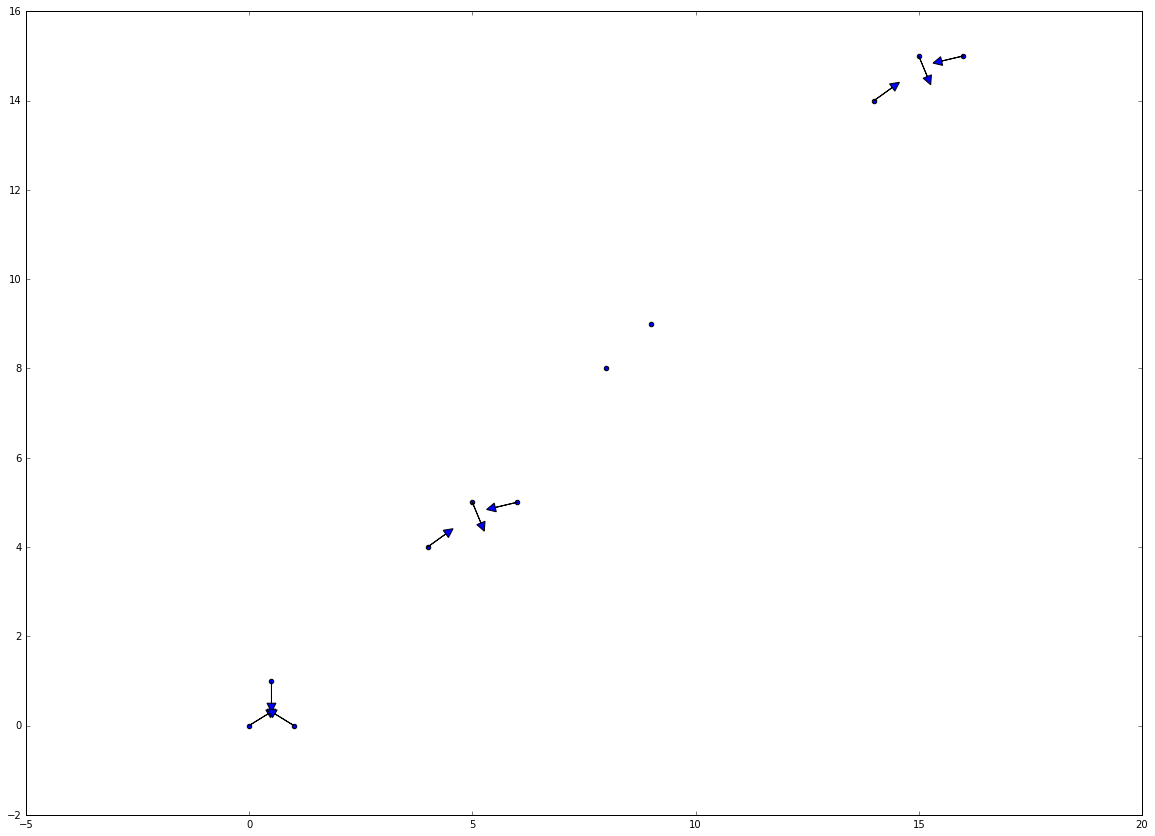

In [205]:
TestLoc = np.array([
        [0, 0],
        [0.5, 1],
        [1, 0],
        [9, 9],
        [8, 8],
        [5, 5],
        [6, 5],
        [4, 4],
        [15, 15],
        [14, 14],
        [16, 15]
    ], dtype=np.float64)

TestOrient = np.array([
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0
    ])

print(TestLoc.dtype)

TestNb = NeighbourMatrix(TestLoc)
print(TestNb)

TestTO, TestDT = NeighbourAngles(TestLoc, TestOrient, TestNb)
print(TestTO)
print(TestDT)

plt.figure(figsize=(20,20))
plt.scatter(TestLoc[:,0], TestLoc[:,1])
plt.gca().set_aspect('equal')

for i in range(TestLoc.shape[0]):
    TIn = TestOrient[i] + TestDT[i]
    print(TIn)
    if(TestTO[i] > np.pi):
        plt.arrow(TestLoc[i,0], TestLoc[i,1], np.cos(TIn)/2, np.sin(TIn)/2, head_width=0.2, head_length=0.2)
plt.show()

In [206]:
max_steps = np.int(1E5);

Torque    = np.zeros([Location.shape[0]])
Force     = np.zeros([Location.shape[0],2])

for step in range(0,max_steps):
    if (step%100 == 0):
        print(step)
    
    Neighbours                       = NeighbourMatrix(Location)
    Boundary, AvgAngles, AngleRange  = NeighbourAngles(Location, Neighbours)
    Overlap                          = NeighbourOverlap(Location, Neighbours, Radius)
    
    Torque[:]          = ParticleTorque(Orientation, AvgAngles, Boundary, T_in, T_noise, T_align)
    AngularVelocity[:] = Torque / (Chi * Radius*Radius)
    Orientation[:]     = Orientation[:] + TimeStep * AngularVelocity
    
    
    Force[:,:]         = ParticleForce(AngleRange, Boundary, Orientation, Overlap, F_self, F_in, k)
    Velocity[:,:]      = np.divide(Force, Zeta*Radius[:,np.newaxis])
    Location[:,:]      = Location[:,:] + TimeStep * Velocity

0


TypeError: not enough arguments: expected 3, got 2

In [ ]:
## Visulaization
fig = plt.figure();
plt.rcParams['figure.figsize'] = (25,25)
ax = plt.gca();
for i in range(Location.shape[0]):
    circle = plt.Circle((Location[i,0], Location[i,1]), Radius[i], color='b', fill=False)
    ax.add_artist(circle);
    ax.arrow(
        Location[i,0],
        Location[i,1],
        0.5 * np.cos(Orientation[i]),
        0.5 * np.sin(Orientation[i]),
        head_width = 0.5,
        head_length = 0.5
    )
a = 1.5;
xd = np.mean(Location[:,0]) - np.abs(np.mean(Location[:,0]) - np.min(Location[:,0])) * a
xu = np.mean(Location[:,0]) + np.abs(np.mean(Location[:,0]) - np.max(Location[:,0])) * a
yd = np.mean(Location[:,1]) - np.abs(np.mean(Location[:,1]) - np.min(Location[:,1])) * a
yu = np.mean(Location[:,1]) + np.abs(np.mean(Location[:,1]) - np.max(Location[:,1])) * a

xu = max(xu, yu);
xd = min(xd, yd);
ax.set_xlim(xd, xu)
ax.set_ylim(xd, xu)
plt.show()